# SIR Model

The SIR model is described by a system of three ordinary differential equations that govern the rate of change of each category (S, I, R) over time. The equations are:

dS/dt = -βSI

dI/dt = βSI - γI

dR/dt = γI

where:

S is the number of susceptible individuals

I is the number of infected individuals

R is the number of recovered individuals

β is the rate of transmission (how quickly the disease spreads from infected to susceptible individuals)

γ is the recovery rate (how quickly infected individuals recover and become immune to the disease)

- The first equation describes the rate of change of the susceptible population, which decreases as individuals become infected. The term -βSI represents the rate at which susceptible individuals become infected.

- The second equation describes the rate of change of the infected population, which increases as individuals become infected and decreases as they recover. The term βSI represents the rate at which susceptible individuals become infected, while the term γI represents the rate at which infected individuals recover.

- The third equation describes the rate of change of the recovered population, which increases as individuals recover from the disease. The term γI represents the rate at which infected individuals recover and become immune to the disease.

- The SIR model is a simple but effective way to model the spread of infectious diseases in a population, and has been used to inform public health policy and decision-making during outbreaks.






# Assumptions

- The population is well-mixed, meaning that each individual has an equal chance of coming into contact with any other individual in the population.

- The disease spreads through direct contact between individuals.

- The rate of transmission depends on the number of infected individuals in the population.

In [53]:
import pandas as pd
import numpy as np
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# Dataset preprocessing

In [54]:
data = pd.read_csv("covid_19_data.csv")
df = data.drop(["Province/State", "Country/Region", "Last Update"], axis =1)
data = df.groupby(['ObservationDate', "Confirmed", "Deaths", "Recovered"])
result = df.groupby(['ObservationDate']).agg({'Confirmed': sum,'Deaths': sum, "Recovered":sum, 'SNo': list}).reset_index()

In [55]:
result = df.groupby(['ObservationDate']).agg({'Confirmed': sum,'Deaths': sum, "Recovered":sum, 'SNo': list}).reset_index()
result = result.sort_values(by='SNo')
result = result.drop(["SNo"], axis =1 )
input_data = pd.DataFrame()

input_data["Confirmed"] = result['Confirmed'].cumsum()
input_data["Deaths"] = result['Deaths'].cumsum()
input_data["Recovered"] = result['Recovered'].cumsum()
input_data = input_data.reset_index()
input_data = input_data.drop(["index"], axis =1)
test_data = input_data
test_data = test_data.tail(50)
input_data = input_data

In [56]:
def dataset(data, orders):
    x_train = []
    for i in range(len(data)  - orders):
        x_train.append(data[i:orders + i])
    return np.array(x_train), data[orders:]

In [57]:
population = 143932377600
X_confirmed = np.array(input_data["Confirmed"])
recovered = np.array(input_data["Recovered"])
death = np.array(input_data["Deaths"])


X = X_confirmed - recovered - death
R = recovered + death
n = np.array([population] * len(X), dtype=np.float64)
S = n - X - R

In [58]:
gamma = (R[1:] - R[:-1]) / X[:-1] #rate at which people recover or die
beta = n[:-1] * (X[1:] - X[:-1] + R[1:] - R[:-1]) / (X[:-1] * (n[:-1] - X[:-1] - R[:-1])) #Transmission rate
R0 = beta / gamma  #reproduction number

In [59]:

x_beta, y_beta = dataset(beta, 10)
x_gamma, y_gamma = dataset(gamma, 10)


In [60]:
import warnings
warnings.filterwarnings("ignore")

beta_ = Ridge(alpha=0.1, fit_intercept=False, normalize=True)
gamma_ = Ridge(alpha=0.1, fit_intercept=False, normalize=True)
beta_.fit(x_beta, y_beta)
gamma_.fit(x_gamma, y_gamma)

#Prediction
beta_pred = beta_.predict(x_beta)
gamma_pred = beta_.predict(x_gamma)


In [65]:
S_predict = [S[-1]]
X_predict = [X[-1]]
R_predict = [R[-1]]

predict_beta = np.array(beta[-10:]).tolist()
predict_gamma = np.array(gamma[-10:]).tolist()
print(S_predict)

[117680325842.0]


In [66]:
for i in range(20): #lags = 10
    next_beta = beta_.predict(np.asarray([predict_beta[-10:]]))[0]
    next_gamma = gamma_.predict(np.asarray([predict_gamma[-10:]]))[0]
    if next_beta<0:
        predict_beta.append(0)
    else:
        predict_beta.append(next_beta)
        
    if next_gamma<0:
        predict_gamma.append(0)
    else:
        predict_gamma.append(next_gamma)
        
    S_predict.append(((-predict_beta[-1] * S_predict[-1] * X_predict[-1]) / n[-1]) + S_predict[-1])
    X_predict.append(((predict_beta[-1] * S_predict[-1] * X_predict[-1]) / n[-1]) - (predict_gamma[-1] * X_predict[-1]) + X_predict[-1])
    R_predict.append((predict_gamma[-1] * X_predict[-1]) + R_predict[-1])


    

In [67]:
def plot():
    plt.figure(1)
    plt.title('SIR Model')
    plt.plot(range(len(X) - 1, len(X) - 1 + len(X_predict)), X_predict, 'o' ,label="Positive Cases", color='darkorange')
    plt.plot(range(len(X) - 1, len(X) - 1 + len(X_predict)), R_predict, 'o', label="Recovered + Death", color='blue')
    plt.plot(range(400,len(X)), X[400:], 'o', label="Predicted Positive Cases", color='red')
    plt.plot(range(400, len(X)), R[400:], 'o', label="Predicted Recovered + Death", color='darkblue')
    plt.xlabel('Time Line(in days)')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

**************************************************
Covid-19 infected cases:  10231128652
Recovered + Deaths:  16181786476
Expected Confirmed cases:  26412915129
**************************************************


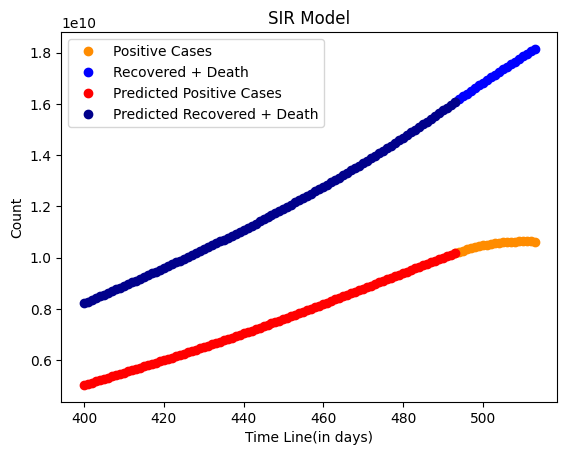

In [68]:
print("*"*50)
print("Covid-19 infected cases: ", int(X_predict[1]))
print("Recovered + Deaths: ", int(R_predict[1]))
print("Expected Confirmed cases: ",int(X_predict[1] + R_predict[1]))
print("*"*50)
plot()